
# Atividade Resolvida

### Classificação de Clientes no BuonoPreço com SVM (RBF)

Este notebook implementa uma solução completa para o problema de **classificação de clientes** usando **Support Vector Machines (SVM)** com kernel **RBF**.

> Observação: os gráficos usam **matplotlib** (sem seaborn) e cada figura em **um único plot**, conforme boas práticas para notebooks avaliativos.


## 1) Imports e Configurações

In [1]:
# Se precisar instalar algo no seu ambiente local, descomente:
# !pip install pandas numpy scikit-learn matplotlib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix 
)
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# Configurações de display
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)
plt.rcParams["figure.figsize"] = (8, 5)

print("Ambiente pronto.")


Ambiente pronto.



## 2) Carregamento do Dataset

Aponte para o CSV exportado do Postgres. Caso o arquivo **não seja encontrado**, o notebook gera um **dataset sintético mínimo** apenas para fins de demonstração.


In [ ]:
# Caminho do CSV (ajuste conforme seu ambiente)
csv_path = "https://raw.githubusercontent.com/sousamaf/AI-Lab/main/datasets/dataset-buonopreco-registro_de_clientes.csv"
# csv_path = "dataset-buonopreco-registro_de_clientes.csv"  # caso queira usar localmente

try:
    if csv_path.startswith("http"):
        df = pd.read_csv(csv_path)
        origem = "CSV do GitHub"
    elif os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        origem = "CSV local"
    else:
        raise FileNotFoundError("Dataset não encontrado.")
except Exception as e:
    # Fallback didático: gera um conjunto simples com 4 classes
    # Caso ocorra falha no CSV será gerado um conjunto sintético para permitir 
    # testes e a realização da atividade.
    rng = np.random.default_rng(42)
    n = 200
    idade = np.clip(rng.normal(40, 12, n).astype(int), 18, 80)
    freq = np.clip(rng.normal(2.5, 1.2, n), 0.2, 8.0)
    gasto = np.clip(rng.normal(250, 180, n), 30, 1500)
    usa_promocao = (rng.random(n) < 0.45).astype(int)
    responde_whatsapp = (rng.random(n) < 0.35).astype(int)
    dia_mais_frequente = (rng.random(n) < 0.5).astype(int)

    # regra simples para rótulos (apenas para fallback)
    classe = []
    for f, g, rp in zip(freq, gasto, responde_whatsapp):
        if f >= 4.0 and g <= 120:
            classe.append("Fiel Econômico")
        elif 0.8 <= f <= 1.8 and g >= 250:
            classe.append("Familiar Mensalista")
        elif rp >= 1:
            classe.append("Reativo a Promoções")
        elif f <= 2.0 and g >= 400:
            classe.append("Alto Valor Ticket Médio")
        else:
            classe.append("Familiar Mensalista")
    df = pd.DataFrame({
        "idade": idade,
        "frequencia_mensal": freq,
        "gasto_medio": gasto,
        "usa_promocao": usa_promocao,
        "responde_whatsapp": responde_whatsapp,
        "dia_mais_frequente": dia_mais_frequente,
        "classe_cliente": classe
    })
    origem = "fallback sintético (gerado)"
print("Origem dos dados:", origem)
print("Formato:", df.shape)
display(df.head())
df.info()


Origem dos dados: CSV do GitHub
Formato: (600, 10)


,cliente_id,idade,frequencia_mensal,gasto_medio,pct_compras_com_desconto,whatsapp_envios,whatsapp_respostas,categoria_preferida,taxa_resposta_whatsapp,classe_cliente
0,C0017f4ca,41,1.09,420.34,16.7,5,3,Laticínios,0.60,Alto Valor Ticket Médio
1,C01418abf,53,1.06,343.02,5.6,2,1,Laticínios,0.50,Alto Valor Ticket Médio
2,C01f7a2b5,34,1.10,380.47,22.2,4,1,Laticínios,0.25,Alto Valor Ticket Médio
3,C02781890,36,1.18,305.87,11.1,1,0,Laticínios,0.00,Familiar Mensalista
4,C02adda22,49,1.02,366.82,17.6,4,2,Mercearia,0.50,Alto Valor Ticket Médio


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cliente_id                600 non-null    object 
 1   idade                     600 non-null    int64  
 2   frequencia_mensal         600 non-null    float64
 3   gasto_medio               600 non-null    float64
 4   pct_compras_com_desconto  600 non-null    float64
 5   whatsapp_envios           600 non-null    int64  
 6   whatsapp_respostas        600 non-null    int64  
 7   categoria_preferida       600 non-null    object 
 8   taxa_resposta_whatsapp    600 non-null    float64
 9   classe_cliente            600 non-null    object 
dtypes: float64(4), int64(3), object(3)
memory usage: 47.0+ KB



## 3) Checagens rápidas e distribuição de classes


Valores ausentes por coluna:
cliente_id                  0
idade                       0
frequencia_mensal           0
gasto_medio                 0
pct_compras_com_desconto    0
whatsapp_envios             0
whatsapp_respostas          0
categoria_preferida         0
taxa_resposta_whatsapp      0
classe_cliente              0
dtype: int64

Distribuição de classes:
classe_cliente
Familiar Mensalista        180
Reativo a Promoções        164
Fiel Econômico             137
Alto Valor Ticket Médio    119
Name: count, dtype: int64


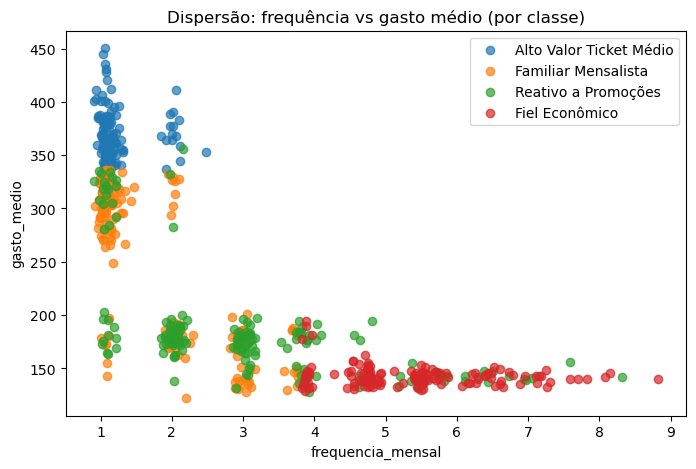

In [8]:
print("Valores ausentes por coluna:")
print(df.isna().sum())

if "classe_cliente" not in df.columns:
    raise ValueError("Coluna 'classe_cliente' não encontrada no dataset.")

print("\nDistribuição de classes:")
print(df["classe_cliente"].value_counts())

# Scatter simples: frequencia vs gasto (colorido por classe)
if all(c in df.columns for c in ["frequencia_mensal","gasto_medio","classe_cliente"]):
    fig = plt.figure()
    classes = df["classe_cliente"].unique()
    for cl in classes:
        sub = df[df["classe_cliente"] == cl]
        plt.scatter(sub["frequencia_mensal"], sub["gasto_medio"], alpha=0.7, label=str(cl))
    plt.xlabel("frequencia_mensal")
    plt.ylabel("gasto_medio")
    plt.title("Dispersão: frequência vs gasto médio (por classe)")
    plt.legend()
    plt.show()



## 4) Pré-processamento

- **Numéricas**: `StandardScaler`  
- **Categóricas**: `OneHotEncoder`  
- Excluímos identificadores como `cliente_id` (se existir).


In [9]:
label_col = "classe_cliente"
drop_cols = ["cliente_id"] if "cliente_id" in df.columns else []

y = df[label_col].copy()
X = df.drop(columns=[label_col] + drop_cols)

# Detecta tipos de forma robusta
numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ]
)


Numéricas: ['idade', 'frequencia_mensal', 'gasto_medio', 'pct_compras_com_desconto', 'whatsapp_envios', 'whatsapp_respostas', 'taxa_resposta_whatsapp']
Categóricas: ['categoria_preferida']


## 5) Split treino/teste

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Shapes: (420, 8) (180, 8) (420,) (180,)


## 6) Treinamento — SVM (RBF)

Fluxograma do pipeline:
<img src="https://sousamaf.github.io/AI-Lab/img/ai-svm-fluxograma-pipeline-buonopreco.png">


In [11]:
svm_rbf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", SVC(kernel="rbf", random_state=42))
])

svm_rbf.fit(X_train, y_train)
y_pred = svm_rbf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Acurácia (teste): {acc:.4f}\n")


Acurácia (teste): 0.8889




## 7) Vetores de Suporte

Para inspecionar os vetores de suporte, transformamos **X_train** com o pré-processamento e treinamos um `SVC` diretamente no espaço transformado.


In [12]:
Xt = svm_rbf.named_steps["prep"].fit_transform(X_train)
clf_rbf = SVC(kernel="rbf", random_state=42).fit(Xt, y_train)

print("Total de vetores de suporte:", clf_rbf.support_vectors_.shape[0])
print("Vetores de suporte por classe:", clf_rbf.n_support_)


Total de vetores de suporte: 288
Vetores de suporte por classe: [68 98 56 66]



## 8) Visualização com PCA (2D)


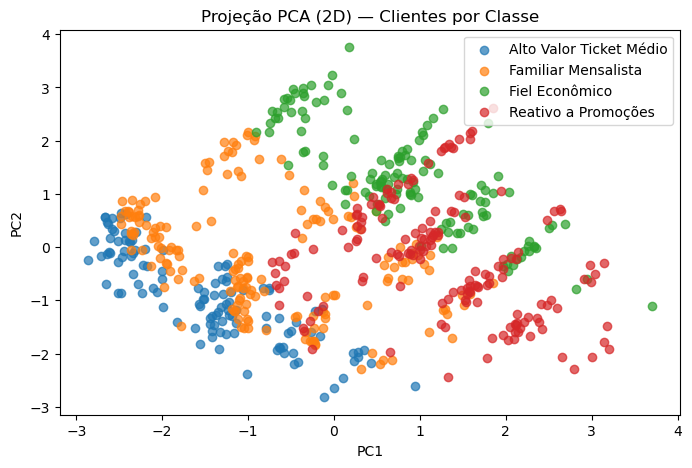

Variância explicada (PC1, PC2): [0.29146391 0.20665492]


In [13]:
Xt_all = svm_rbf.named_steps["prep"].fit_transform(X)
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(Xt_all)

fig = plt.figure()
for cl in np.unique(y.values):
    idx = (y.values == cl)
    plt.scatter(Z[idx, 0], Z[idx, 1], alpha=0.7, label=str(cl))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Projeção PCA (2D) — Clientes por Classe")
plt.legend()
plt.show()

print("Variância explicada (PC1, PC2):", pca.explained_variance_ratio_)



## 9) Sobrepor a fronteira de decisão do SVM

Um extra avançado!

Sobrepondo a fronteira de decisão no plano do PCA sem “mexer” no modelo treinado.

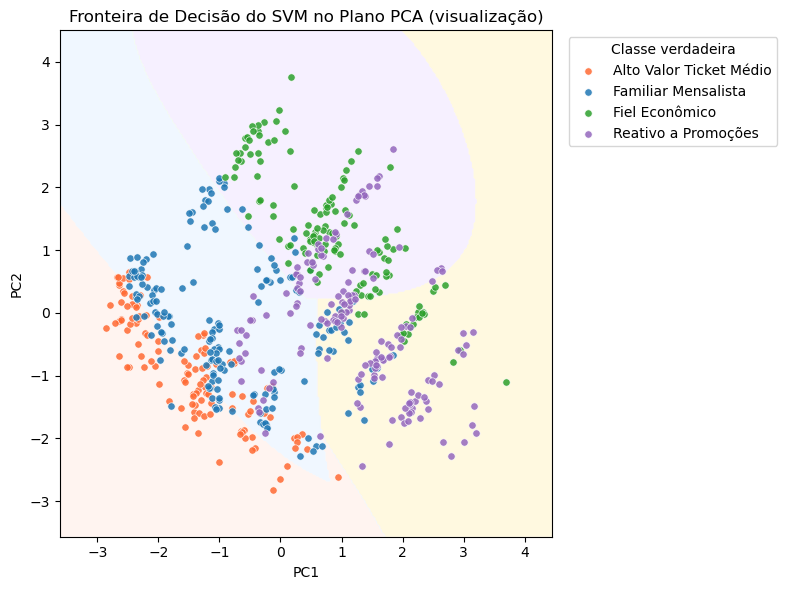

In [14]:
# 1) constrói a malha em PC1 x PC2
pad = 0.75
x_min, x_max = Z[:, 0].min() - pad, Z[:, 0].max() + pad
y_min, y_max = Z[:, 1].min() - pad, Z[:, 1].max() + pad
res = 300  # resolução da malha (aumente para uma borda mais suave)

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, res),
    np.linspace(y_min, y_max, res)
)
grid_pca = np.c_[xx.ravel(), yy.ravel()]

# 2) volta do espaço PCA -> espaço pré-processado (Xt)
grid_preprocessed = pca.inverse_transform(grid_pca)

# 3) prediz classes no grid usando o SVM treinado no espaço pré-processado
Z_pred = clf_rbf.predict(grid_preprocessed)
Z_pred = Z_pred.reshape(xx.shape)

# 4) mapa de cores discreto (uma cor por classe)
classes = np.unique(y)
# criando um mapeamento classe -> índice
cls_to_idx = {c: i for i, c in enumerate(classes)}
idx_pred = np.vectorize(cls_to_idx.get)(Z_pred)

# paleta simples (ajuste se tiver mais de 4 classes)
cmap_bg = ListedColormap(["#FFEEE6", "#E6F2FF", "#EAF7EA", "#F0E6FF", "#FFF5CC"])
cmap_pts = ["#FF6A33", "#1F77B4", "#2CA02C", "#9467BD", "#BCBD22"]

# 5) plota a fronteira (contourf) + pontos reais no plano PCA
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, idx_pred, levels=len(classes), cmap=cmap_bg, alpha=0.6, antialiased=True)

# pontos
for i, cl in enumerate(classes):
    mask = (y.values == cl)
    plt.scatter(Z[mask, 0], Z[mask, 1], s=28, alpha=0.85, edgecolor="white", linewidth=0.5,
                label=str(cl), color=cmap_pts[i % len(cmap_pts)])

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Fronteira de Decisão do SVM no Plano PCA (visualização)")
plt.legend(title="Classe verdadeira", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


## 10) Interpretação de Negócio (breve)

Sugestões de leitura do resultado:

- Se a classe 'Reativo a Promoções' confunde com 'Fiel Econômico', pode faltar uma feature de engajamento.
